# Replicate tail tracking algorithm from stytra
- The centroid-based algorithm from `stytra/tracking/tail.py`
- Something got fucked up when I updated jupyter-lab -- newly installed kernels crash with AsyncIO related issues when running matplotlib functions, even when conda envs are identical!

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image

## Load test image
- think about thresholding etc later

In [2]:
test_image_path = './asset/bent_tail.bmp'
img = np.array(Image.open(test_image_path))

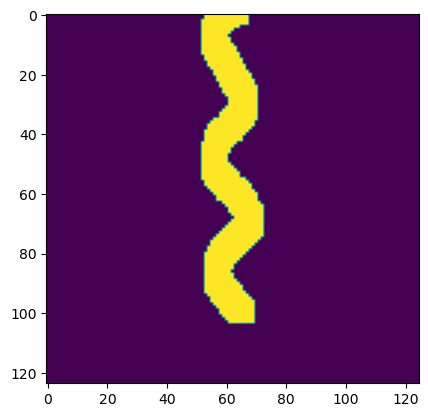

In [3]:
plt.imshow(img)

### Define tail base- and tip-points
- Eventually this needs to be provided through a GUI
- Here we just provide them, looking at the image

In [4]:
# Tail base and end, in pixel units
base_x = 60
base_y = 5
tip_x = 60
tip_y = 110
n_seg = 7
search_radius = 7 # pixel

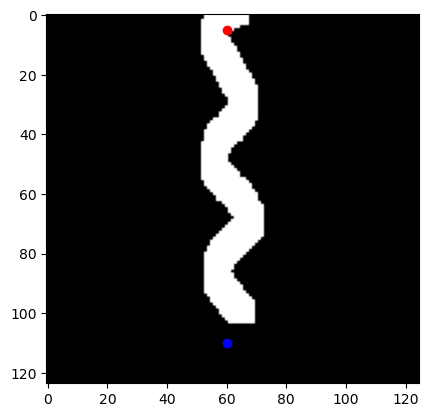

In [5]:
# visualize
plt.figure()
plt.imshow(img, cmap='Greys_r')
plt.scatter(base_x, base_y, color='red')
plt.scatter(tip_x, tip_y, color='blue')
plt.show()

## Find tail segments by recursively calculating center-of-mass
- Provided the base and tip points as well as #segments, calculate expected point of the end of the first segment
- Calculate COM around this expected point, within a set radius
- Using this COM as the new "base" and the first base-COM vector as the template of the next segment, repeat the process
- Repeat for the all segments

In [6]:
# given the base and tip points and #segments, calculate first segment displacement
length_tail = np.sqrt((tip_x-base_x)**2 + (tip_y-base_y)**2)
length_seg = length_tail / n_seg

print('tail length (px):', length_tail)
print('segment length (px):', length_seg)

tail length (px): 105.0
segment length (px): 15.0


In [7]:
# in the end this needs to be speed optimized
# stytra uses numba njit, so the function is pre-compiled
# we just make sure to pass the values of the right type

def find_tip_with_com(image, base_x, base_y, dx, dy, segment_length, radius):
    """
    Given the base of the current segment and the guessed location of its tip,
    calculate the image intensity center-of-mass (COM) around this guessed point, 
    and define the tip as the point on the base-to-COM line with the distance
    pre-determined by the segment length.

    Parameters
    -----------
    image : image of fish tail
    base_x : base x of this segment (px)
    base_y : base y of this segment (px)
    dx : initial guess of where tip would be relative to base_x
    dy : initial guess of where tip would be relative to base_y
    radius : radius within which we calcualte the COM
    """
    
    # First, prepare integer indices to define the area within which we calculate COM
    x0 = int(np.clip(base_x + dx - radius, 0, image.shape[1]))
    x1 = int(np.clip(base_x + dx + radius, 0, image.shape[1]))
    y0 = int(np.clip(base_y + dy - radius, 0, image.shape[0]))
    y1 = int(np.clip(base_y + dy + radius, 0, image.shape[0]))
    

    # return invalid values if the area is entirely outside the image
    if x0==x1 and y0==y1:
        print('search out of image')
        return -1, -1, 0, 0

    # loop through all pixels in [x0, x1], [y0, y1] and calculate the product of the position & intensity
    # would it be faster if we use numpy array? Or it doesn't matter if we do njit?
    radius2 = radius**2
    summed_ix = 0.0
    summed_iy = 0.0
    total_intensity = 0.0
    for x in range(x0, x1):
        for y in range(y0, y1):
            # Make sure that the pixel we are looking at is inside the radius
            this_pixel_dist2_from_guess = (x0+radius-x)**2 + (y0+radius-y)**2
            if this_pixel_dist2_from_guess <= radius2:
                summed_ix += image[y, x] * x
                summed_iy += image[y, x] * y
                total_intensity += image[y, x]

    # if no pixel has positive value wihthin the search area, we return error (negative base_x)
    if total_intensity==0.0:
        print('no positive pixel found')
        return -1, -1, 0, 0

    
    # get the COM (this is in the absolute pixel coordinate)
    com_x = summed_ix / total_intensity
    com_y = summed_iy / total_intensity

    # now, calculate new dx/dy by forcing the pre-defined segment legnth
    length_ratio = segment_length / np.sqrt((com_x - base_x)**2 + (com_y - base_y)**2)
    new_dx = (com_x - base_x) * length_ratio
    new_dy = (com_y - base_y) * length_ratio
    
    # return values can be exactly interpreted as base_x/y, dx/y for the next iteration
    return base_x+new_dx, base_y+new_dy, new_dx, new_dy

In [8]:
# The function to calculate the "tail sum", which is basically the relative angle of the last segment
# Calls the tip-finding function iteratively. Gives up once it doesn't find a segment

def calc_tail_angle(image, base_x, base_y, tip_x, tip_y, n_segments, radius):
    """
    Given the fish image and manually defined base/tip points at rest, 
    the desired number of segments, calculate the tail angle (that is, the
    relative angle of the last segments) by iteratively calling the 
    segment finding function. Aborts once it does not find a segment and 
    return NaN.

    Parameters
    -----------
    image : image of fish tail
    base_x : base x of the whole tail (px)
    base_y : base y of the whole tail (px)
    tip_x : tip x of the whole tail at rest (px)
    tip_y : tip y of the whole tail at rest (px)
    n_segments : number of segments
    radius : radius within which we calcualte the segment tip COM (px)
    """

    # flag to abort
    bad_tracking_flag = False

    # First, calculate the lenght of each segment
    length_tail = np.sqrt((tip_x-base_x)**2 + (tip_y-base_y)**2)
    length_seg = length_tail / n_segments

    # define the base and estimated tip of the first segment
    bx = base_x
    by = base_y
    dx = (tip_x - base_x) / n_segments
    dy = (tip_y - base_y) / n_segments

    # iteratively call the tip finding function
    # because we only ever care about the overall tail angle, 
    # we do not log x/y positions, but just angles

    angles = np.full(n_segments, np.nan)
    for i in range(n_segments):
        bx, by, dx, dy = find_tip_with_com(img, bx, by, dx, dy, length_seg, search_radius)
        # if bx < 0, it means that something went wrong (tail lost etc). We just return nan
        if bx < 0:
            bad_tracking_flag = True
            break
        angles[i] = np.arctan2(dx, dy)

    if bad_tracking_flag:
        return np.nan
    else: # we have valid tracking
        angles = np.unwrap(angles)
        # "tail sum" is the difference between the first and last segments
        return angles[-1] - angles[0]

In [9]:
bx = base_x
by = base_y
dx = (tip_x - base_x) / n_seg
dy = (tip_y - base_y) / n_seg

segments = [(bx, by)]

for i in range(n_seg):
    bx, by, dx, dy = find_tip_with_com(img, bx, by, dx, dy, length_seg, 15)
    angle = np.arctan2(dx, dy)
    segments.append((bx, by))
    print('segment', i, 'tip x/y', bx, by, 'l_seg', np.sqrt(dx**2+dy**2), 'angle', angle)

segment 0 tip x/y 61.253289900296565 19.947550449013864 l_seg 14.999999999999998 angle 0.08365018086477002
segment 1 tip x/y 61.99760271102855 34.929072349000535 l_seg 15.000000000000002 angle 0.049641239629775416
segment 2 tip x/y 59.5207615620223 49.72316772258081 l_seg 15.000000000000002 angle -0.16588246162459092
segment 3 tip x/y 62.22870602624476 64.4767109166304 l_seg 15.0 angle 0.181524903057357
segment 4 tip x/y 61.93537611360758 79.4738425611267 l_seg 15.0 angle -0.01955657408519095
segment 5 tip x/y 60.075497228142815 94.35809096443556 l_seg 14.999999999999998 angle -0.12431185262336772
segment 6 tip x/y 67.31042255665352 107.49794847853647 l_seg 14.999999999999998 angle 0.5033107419814874


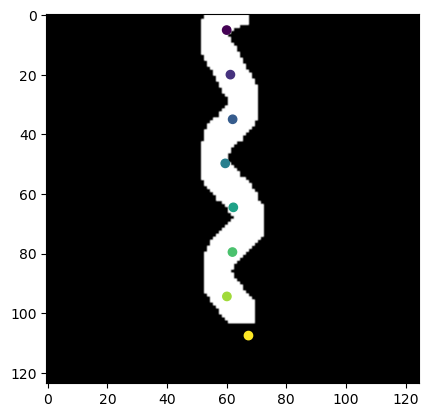

In [10]:
# visualize
segments = np.asarray(segments)

plt.figure()
plt.imshow(img, cmap='Greys_r')
plt.scatter(segments[:, 0], segments[:, 1], c=np.arange(n_seg+1))
plt.show()

In [11]:
# comaprtmentalized in a function
print(calc_tail_angle(img, base_x, base_y, tip_x, tip_y, 10, 15))

0.3827534267634366


nan